In [2]:
## General Imports

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
poly,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from patsy import dmatrix

## Lab Specific Imports
from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)
from scipy.interpolate import BSpline
from ISLP.transforms import (BSpline,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)

## sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
## load wage data
wage = load_data('Wage')

# isolate variables
y = wage['wage']
age = wage['age']

display(wage)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [4]:
## GAM is specified by associating each column of model matrix with a smoothing operation
## In this case, the argument 0 passed to s indicates that this smoother will apply to the first column (X_age)
## The argument "lam" is the penalty parameter lambda 

X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

## WE have reshaped age to be a a matrix

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

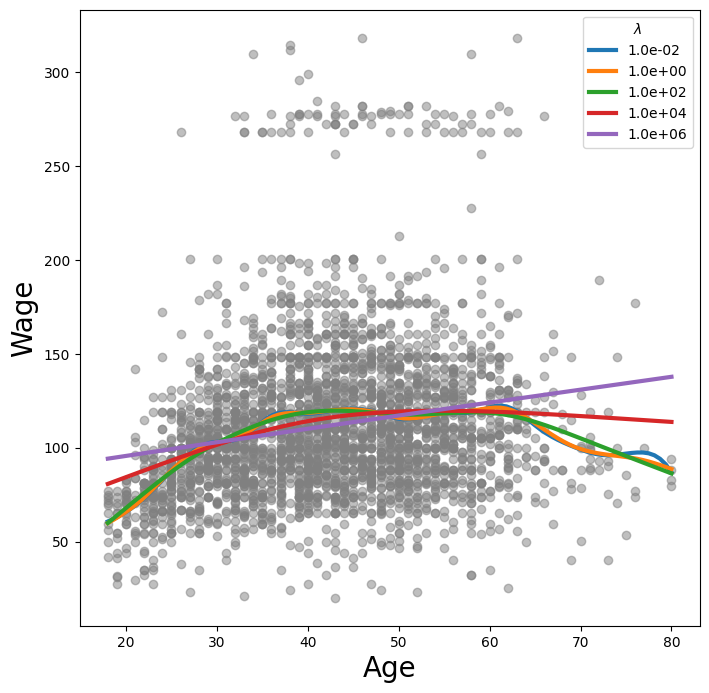

In [5]:
## Create a grid of values for age at which we want predictions

age_grid = np.linspace(age.min(),
age.max(),
100)
age_df = pd.DataFrame({'age': age_grid})


## Here we want to see how the fit changes with the smoothing parameter lam

fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
        gam.predict(age_grid),
        label='{:.1e}'.format(lam),
        linewidth=3)
    
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$')

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


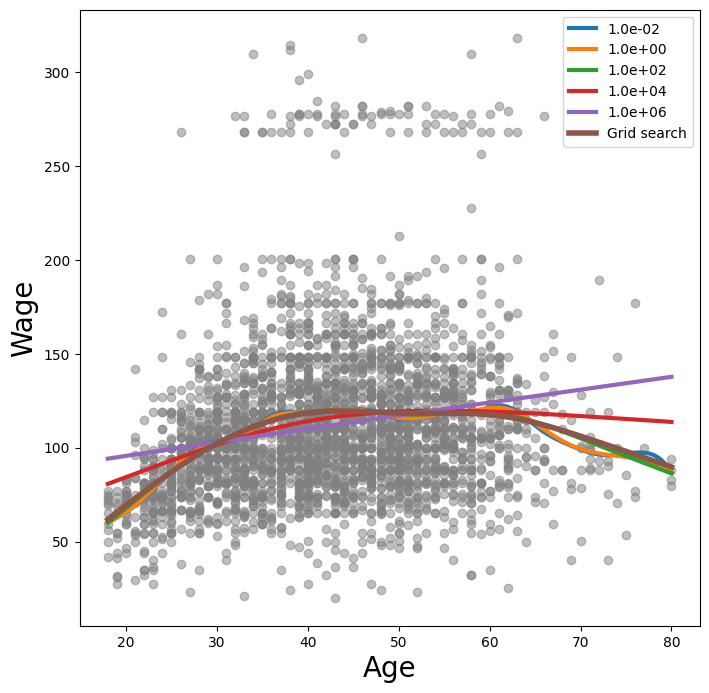

In [6]:
## pygam can also perform a search for an optimal smoothing parameter

gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
    gam_opt.predict(age_grid),
    label='Grid search',
    linewidth=4)
ax.legend()
fig

In [7]:
## In the ISLP package we can also find a value of lambda that gives us a specified number of df
## Here, we choose 4

age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100000719

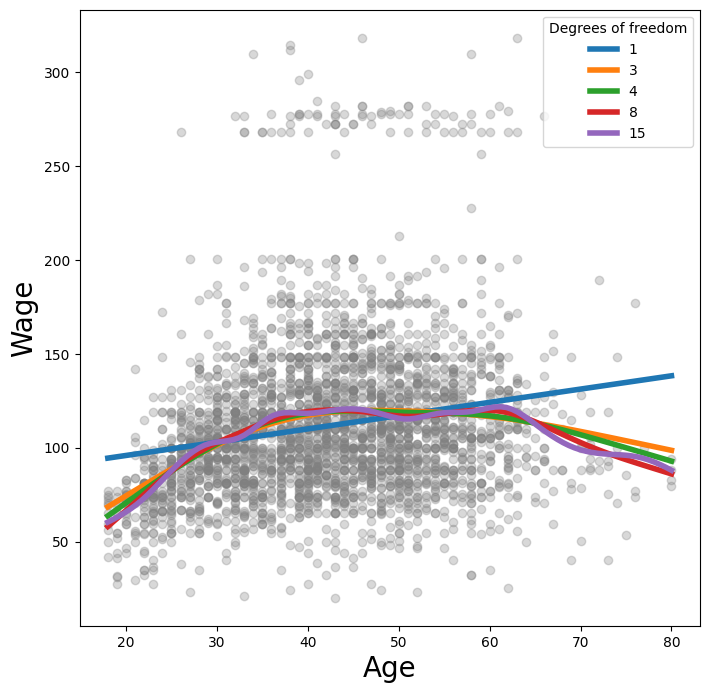

In [8]:
## here we vary the degrees of freedom in the chart above
## We choose the df as the desired df + 1 to account for the fact that smoothing splines always have an intercept term

fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
    y,
    facecolor='gray',
    alpha=0.3)

for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
        gam.predict(age_grid),
        label='{:d}'.format(df),
        linewidth=4)
    

ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom')

## Additive Models with Several Terms

In [9]:
## We first fit a GAM by hand to predict wage using natural spline functions of year and age, with education as a qualitative predictor
## We can do this with OLS since it's just a big linear regression using basis functions

ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(wage['year'])
Xs = [ns_age.transform(age),
    ns_year.transform(wage['year']),
    pd.get_dummies(wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

## We use all columns of the indicator matrix for the categorial variable education
## We stacked the three component matrices horizontally to form the model matrix 

Text(0.5, 1.0, 'Partial dependence of age on wage')

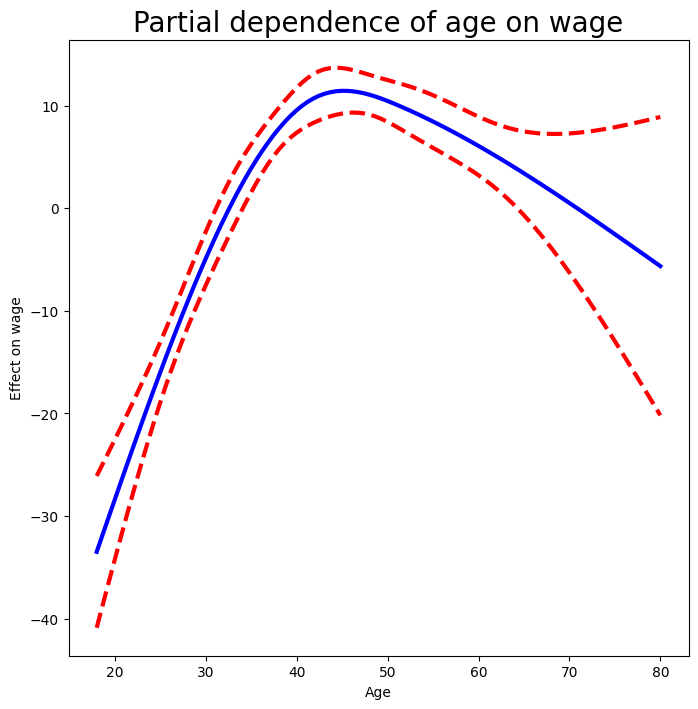

In [10]:
## We make a grid of length 100 in age with the same number of columns as X_bh
## We replace every row of this matrix with the column means of the original
## We replace teh first four columns representing age with the natural spline basis computed at the values in age_grid

age_grid = np.linspace(age.min(),
        age.max(),
        100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20)

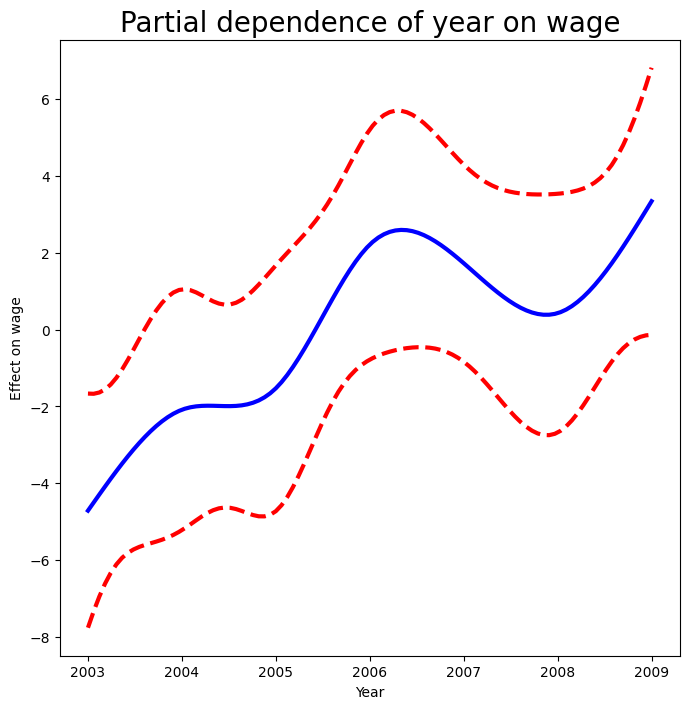

In [11]:
## Perform the same as the above but with year

year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(wage['year'].min(),
wage['year'].max(),
100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year , 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

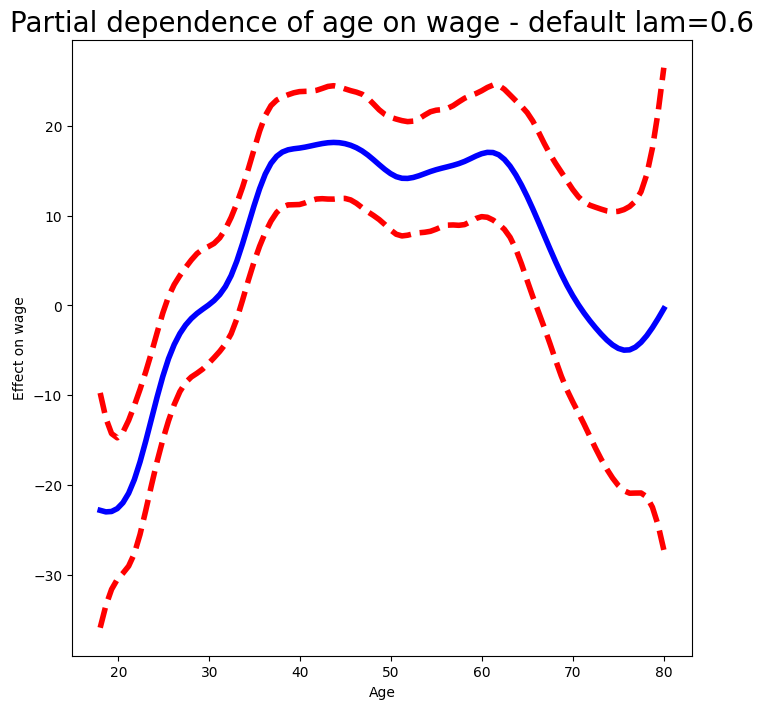

In [12]:
## We now fit the model using smoothing splines rather than natural splines

gam_full = LinearGAM(s_gam(0) +
    s_gam(1, n_splines=7) +
    f_gam(2, lam=0))
Xgam = np.column_stack([age,
    wage['year'],
    wage['education'].cat.codes])

gam_full = gam_full.fit(Xgam, y)

## pygam only works with matricies, so we convert the categorical series education to it's array representation
## year only has 7 values so we use only seven basis functions for it 

## The two s_gam terms result in smoothing spline fits and use the default lam = 0.6
## Categorical term uses f_gam, where 0 is the lam to avoid any shrinkage

## Below we produce the partial dependence plot in age

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6',
    fontsize=20)

Text(0.5, 1.0, 'Partial dependence of year on wage')

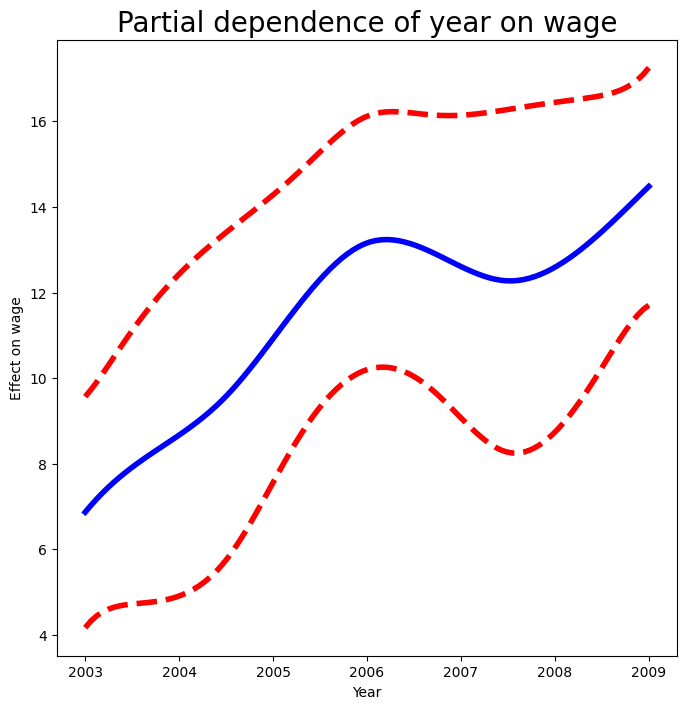

In [13]:
## The function is somewhat wiggly
## We specify the df than a value for lam, refitting with 4 df + 1

age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
    1,
    ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

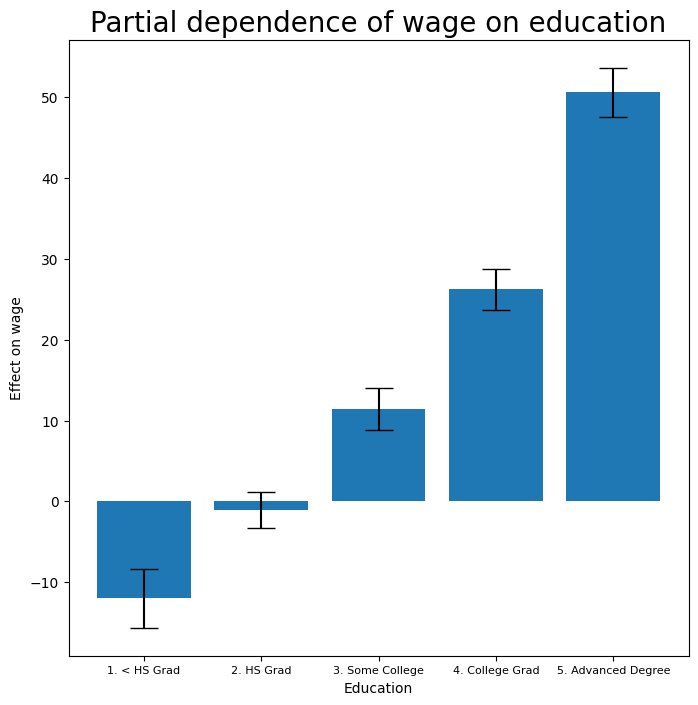

In [14]:
## Finally we plot the partial dependence plot for education, the categorical variable

fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
    fontsize=20);
ax.set_xticklabels(wage['education'].cat.categories, fontsize=8);


## ANOVA tests for additive models

In [15]:
## In all our models, the function of year looks linear
## We perform a series of ANOVA tests to determine which of these three models is best
    ## GAM that excludes year
    ## GAM that uses a linear function of year
    ## GAM that uses a spline function of year 

In [16]:
## Here we define GAM_0, the GAM that excludes year, and gam_linear for the gam wit a linear function of year

gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
    l_gam(1, lam=0) +
    f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [17]:
anova_gam(gam_0, gam_linear, gam_full)

## There is compelling evidence that a GAM with a linear function in year is better than a GAM that doesn't include year at all (p-value = 0.002)
## No evidence that a non-linear function of year is needed (p = 0.435)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [18]:
## Here we repeat the same process for age

gam_0 = LinearGAM(year_term +
        f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
            year_term +
            f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

## Because of the low p-values, it is clear that a non-linear term is needed for age

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [19]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

C:\Users\lucas\AppData\Local\Temp\ipykernel_12552\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


## Logistic GAM

In [20]:
## We can also fit a Logistic GAM from pygam

high_earn = wage['wage'] > 250

gam_logit = LogisticGAM(age_term +
        l_gam(1, lam=0) +
        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

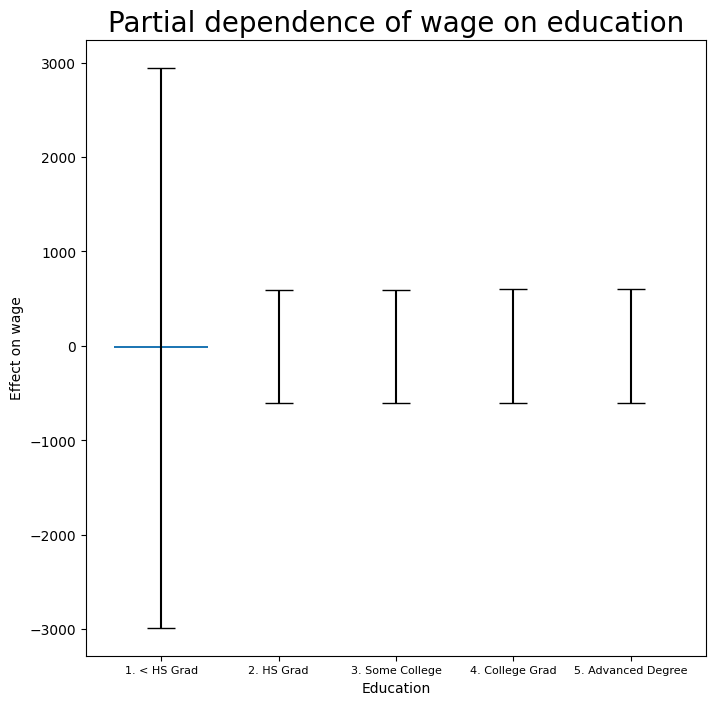

In [21]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(wage['education'].cat.categories, fontsize=8)

## This model is very flat, with high error for first category

In [22]:
pd.crosstab(high_earn, wage['education'])

## There are no high earners in the first category, so we'll exclude it 

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
wage,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [23]:
wage['high_earn'] = high_earn

only_hs = wage['education'] == '1. < HS Grad'
wage_ = wage.loc[~only_hs]
Xgam_ = np.column_stack([wage_['age'],
    wage_['year'],
    wage_['education'].cat.codes -1])
high_earn_ = wage_['high_earn']

In [24]:
gam_logit_ = LogisticGAM(age_term +
        year_term +
        f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '2. HS Grad'),
 Text(1, 0, '3. Some College'),
 Text(2, 0, '4. College Grad'),
 Text(3, 0, '5. Advanced Degree')]

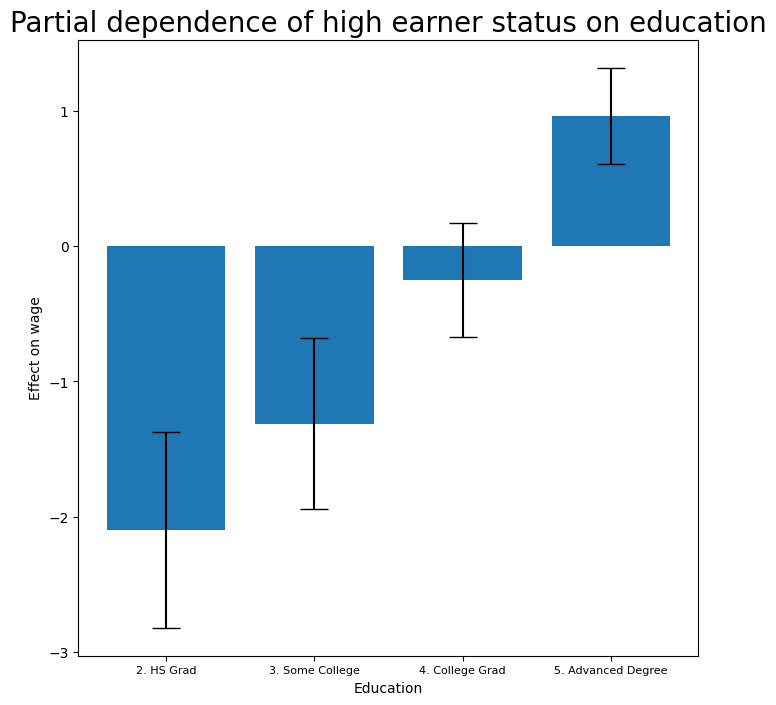

In [25]:
## Now we look at the effect of education, year, and age after removing the observations

fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20)
ax.set_xticklabels(wage['education'].cat.categories[1:],
fontsize=8)

Text(0.5, 1.0, 'Partial dependence of high earner status on year')

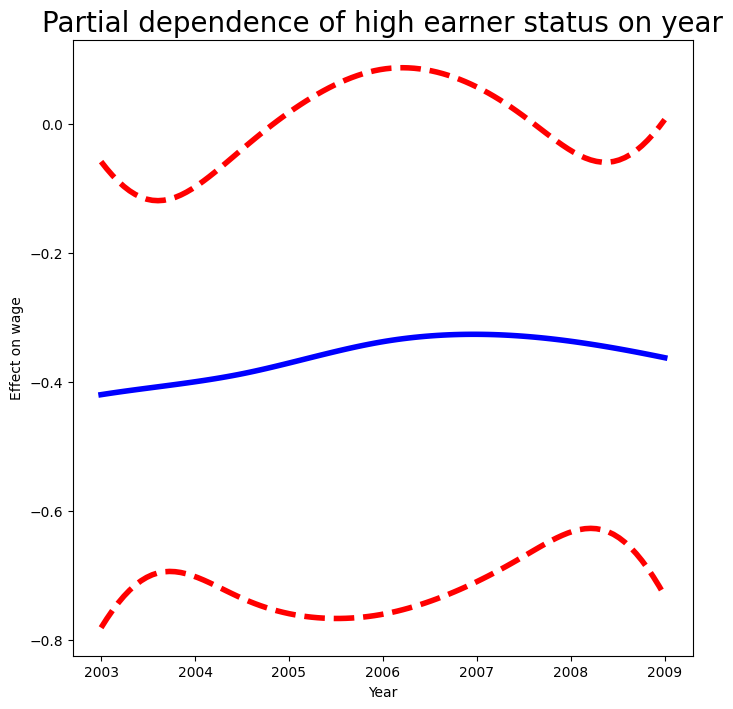

In [26]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
    fontsize=20)

Text(0.5, 1.0, 'Partial dependence of high earner status on age')

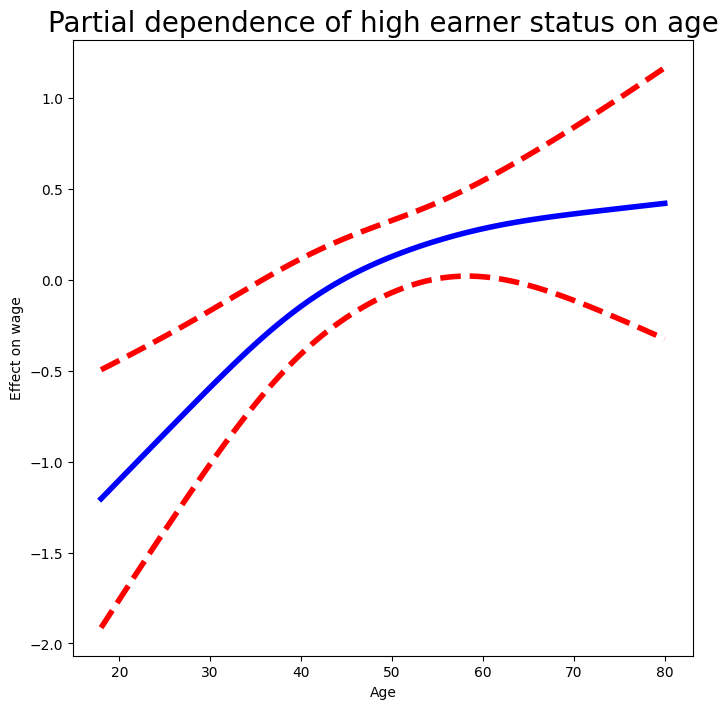

In [27]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age',
fontsize=20)

## 7.8.4 Local Regression

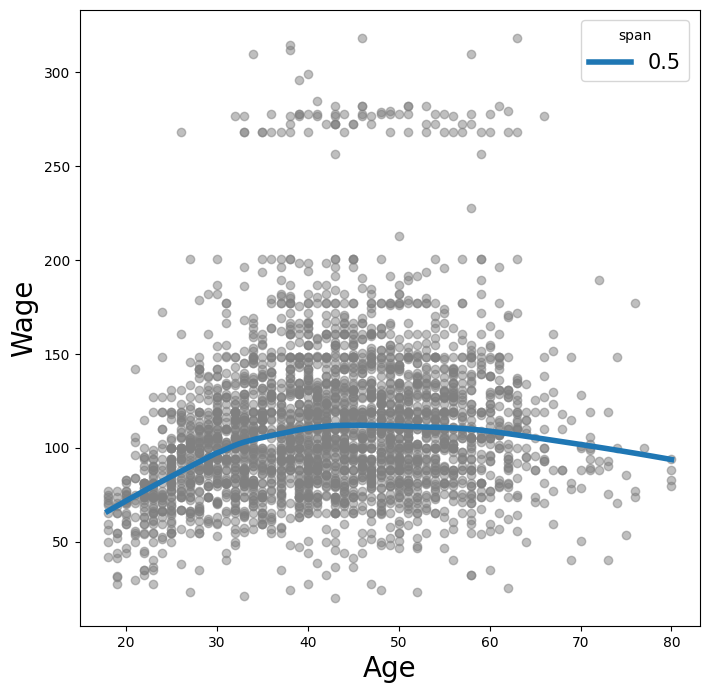

In [28]:
## Uses lowess function from sm.nonparametric

## We fit local linear regression models using spans of 0.2 and 0.5
    ## Each neighborhood consists of 20% or 50% of the observations.

lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
        age,
        frac=span,
        xvals=age_grid)
    
ax.plot(age_grid,
    fitted,
    label='{:.1f}'.format(span),
    linewidth=4)

ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15)